In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
#define constant
rnn_unit=10       #hidden layer units
input_size=6      
output_size=1
lr=0.0006    # learning rate
test_len=180 #test lenth
batch_size=14
train_begin=0
train_end=6000
wind_data_raw = pd.read_csv('wind2012.csv',skiprows=3)
print("Number of original data : ", len(wind_data_raw))
wind_data=[]
#calculate the mean value for every hour and save as a new dataframe
for i in range(len(wind_data_raw)//12):
    wind_data.append(wind_data_raw[i*12:(i+1)*12].mean())
wind_data=pd.DataFrame(wind_data)
wind_data=wind_data.iloc[:,5:11]
label=pd.DataFrame(wind_data.iloc[1:,0].values)
wind_data['label']=label
wind_data=wind_data.drop([8782])
print("Number of hourly averaged data : ", len(wind_data))
wind_data=wind_data.values

Number of original data :  105407
Number of hourly averaged data :  8782


In [2]:
def get_data(batch_size=14, time_step=6, train_begin=0, train_end=6000):
    # setting training set
    batch_index=[]
    # nomalize the data
    ## create the scaler from the wind data 
    train_scaler_1 = MinMaxScaler(feature_range=(0,1))
    ## apply the scaler transform to the wind data
    nor_wind_data = train_scaler_1.fit_transform(wind_data)
    train_data=nor_wind_data[train_begin:train_end]
    train_scaler = MinMaxScaler(feature_range=(0,1))
    m=train_scaler.fit_transform(wind_data[:, 6].reshape(-1, 1))
    ## define trainning set x and y
    train_x,train_y=[],[]
    for i in range(len(train_data)-time_step):
        if i % batch_size == 0:
            batch_index.append(i)
        x=train_data[i:i+time_step,:-1]
        y=train_data[i:i+time_step,-1,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    batch_index.append((len(train_data)-time_step))
    # setting testing data
    test_data=nor_wind_data[train_end:(train_end+test_len)]
    size=test_len//time_step
    test_x=[]                
    test_y=test_data[:,-1]   
    for i in range(size):
        x=test_data[i*time_step:(i+1)*time_step,:-1]
        #y=test_data[i*time_step:(i+1)*time_step,-1]
        test_x.append(x.tolist())
        #test_y.extend(y)
    print (np.array(train_x).shape)
    print (np.array(train_y).shape)
    print (np.array(test_x).shape)
    print (len(test_y))
    return batch_index,train_x,train_y, test_x, test_y, train_scaler

    
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
        }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
       }
    

In [3]:
def lstm(X):
    batch_size=tf.shape(X)[0]
    time_step=tf.shape(X)[1]
    w_in=weights['in']
    b_in=biases['in']  
    input=tf.reshape(X,[-1,input_size])  #transform tensor into 2 dimentions to calculate, the results set as the input of the hidden layer
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit]) #transform tensor into 3 dimentions，as the input of the lstm cell
    cell=tf.contrib.rnn.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch_size,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,
                                              initial_state=init_state, dtype=tf.float32)   
    #output_rnn records the results of every node of lstm' output，final_states is the results of the last cell
    output=tf.reshape(output_rnn,[-1,rnn_unit])
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

In [4]:
def train_lstm(batch_size=14,time_step=6,train_begin=0,train_end=6000):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
    batch_index,train_x,train_y,test_x,test_y,train_scaler=get_data()
    pred,_=lstm(X)
    #loss function
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    loss_data=[]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #saver.restore(sess, module_file)
        #trainning for specified times
        steps=20
        for i in range(steps):
            for step in range(len(batch_index)-2):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],
                                                            Y:train_y[batch_index[step]:batch_index[step+1]]})
            loss_data.append(loss_)
            print("Number of iterations:",i," loss:",loss_)

        print("The train has finished")
        
        #prediction
        test_predict=[]
        for step in range(len(test_x)):
            prob=sess.run(pred,feed_dict={X:[test_x[step]]})   
            predict=prob.reshape((-1))
            test_predict.extend(predict)
        test_predict=np.array(test_predict).reshape(-1,1)
        test_y=np.array(test_y).reshape(-1,1)
        test_predict=train_scaler.inverse_transform(test_predict).reshape(-1,1)
        test_y=train_scaler.inverse_transform(test_y).reshape(-1,1)
        rmse = np.sqrt(mean_squared_error(test_predict, test_y))
        mae = mean_absolute_error(y_pred=test_predict, y_true=test_y)
        #print('accuracy=', acc)
        print('rmse=',rmse,'   mae=',mae)
        plt.figure()
        plt.plot(list(range(len(test_predict))),test_predict,color='b')
        plt.plot(list(range(len(test_y))),test_y,color='r')
        plt.show()
        return test_predict, loss_data, test_y

Number of iterations: 0  loss: 0.007834756
Number of iterations: 1  loss: 0.0064813863
Number of iterations: 2  loss: 0.0059808563
Number of iterations: 3  loss: 0.0056865825
Number of iterations: 4  loss: 0.005491039
Number of iterations: 5  loss: 0.005360163
Number of iterations: 6  loss: 0.005271625
Number of iterations: 7  loss: 0.005208195
Number of iterations: 8  loss: 0.0051589017
Number of iterations: 9  loss: 0.005117882
Number of iterations: 10  loss: 0.005082359
Number of iterations: 11  loss: 0.005051116
Number of iterations: 12  loss: 0.0050236364
Number of iterations: 13  loss: 0.0049996576
Number of iterations: 14  loss: 0.0049789473
Number of iterations: 15  loss: 0.0049612517
Number of iterations: 16  loss: 0.004946227
Number of iterations: 17  loss: 0.0049334406
Number of iterations: 18  loss: 0.0049224235
Number of iterations: 19  loss: 0.0049126907
The train has finished
rmse= 0.22034179469671433    mae= 0.1441259236652542


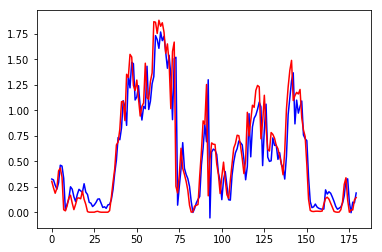

In [5]:
test_predict, loss_data, test_y=train_lstm()

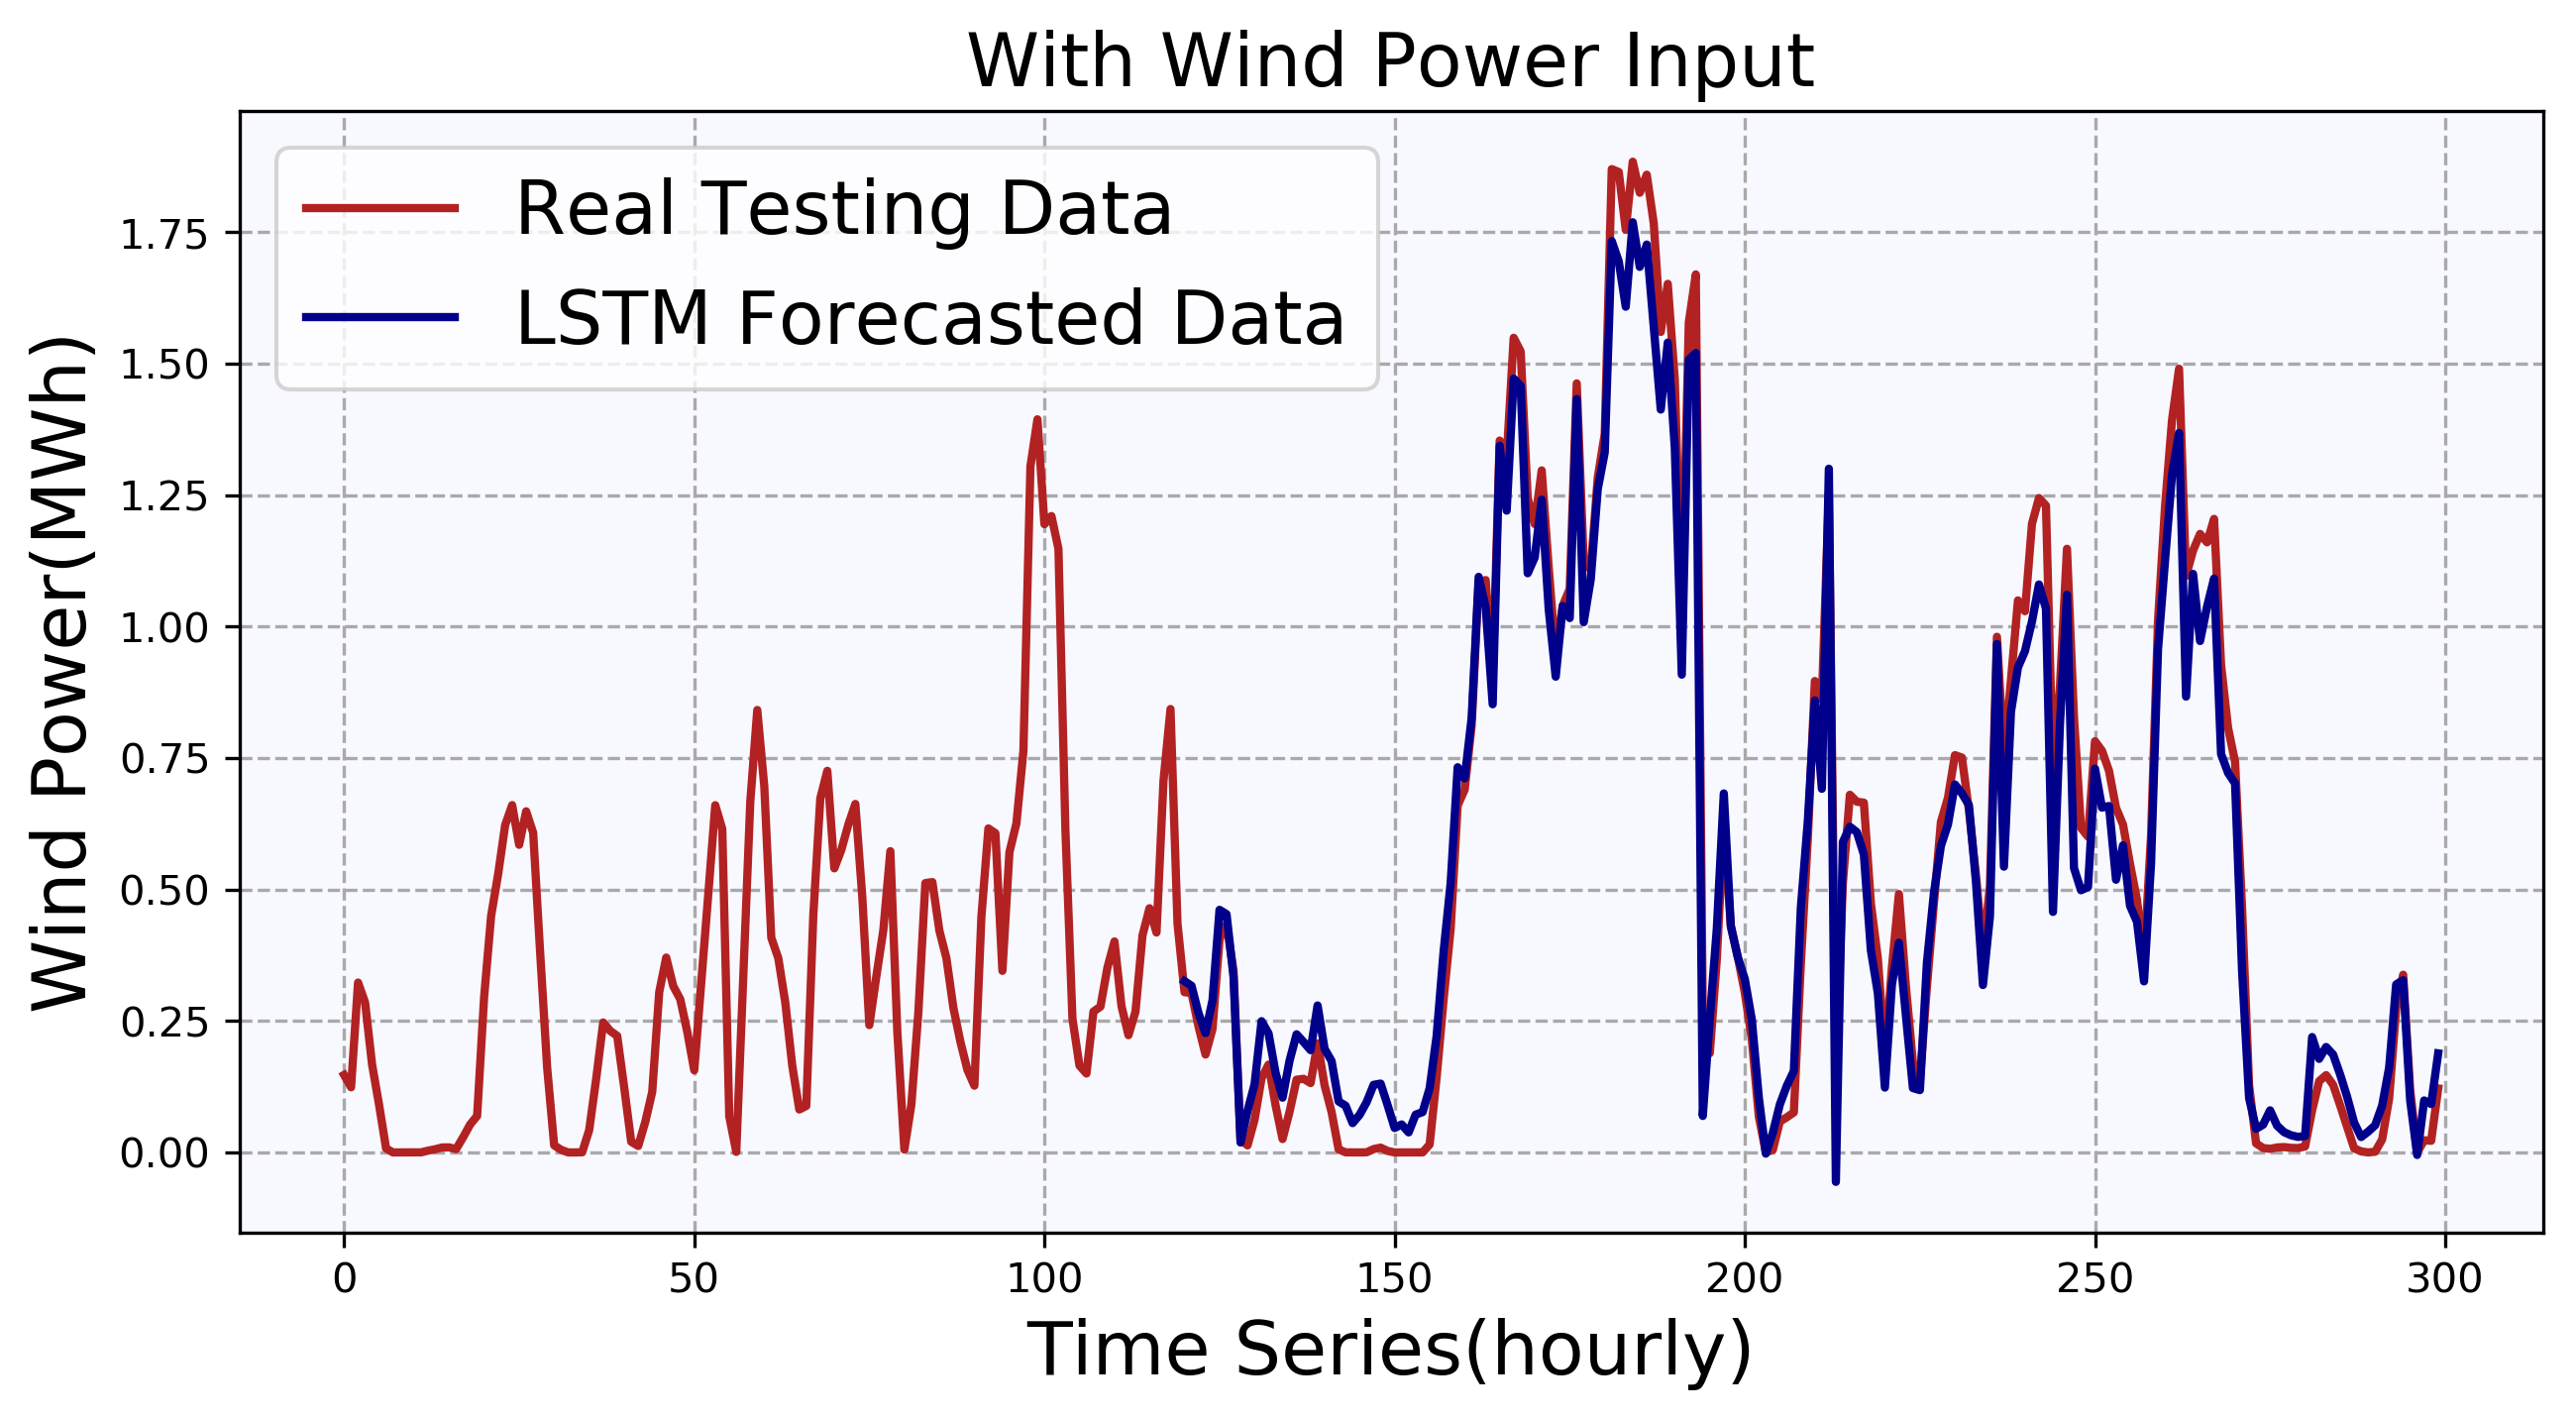

In [7]:
figure = plt.figure(dpi = 300, figsize=(10,5))
axes = figure.add_subplot(1, 1, 1, facecolor='ghostwhite')
plot_data = wind_data[:, 0]
axes.plot( plot_data[5880:6180], lw='2', c =  'firebrick', label='Real Testing Data')  
axes.plot([None for _ in range(120)] + [x for x in test_predict], lw='2', c ='darkblue', label= 'LSTM Forecasted Data') 
axes.set_title('With Wind Power Input', fontsize = 18)
axes.set_xlabel('Time Series(hourly)', fontsize = 18)
axes.set_ylabel('Wind Power(MWh)', fontsize = 18)
axes.grid(ls = '--' , c = 'darkgrey')
axes.legend(fontsize=18)
figure.savefig('Forecasted Wind Power.png')